In [ ]:
# # KNN (k-Nearest Neighbors) - Метод ближайших соседей
#
# В этом ноутбуке мы рассмотрим:
# 1. Собственную реализацию алгоритма KNN с различными метриками
# 2. Реализацию из библиотеки scikit-learn
# 3. Визуализацию работы алгоритма
# 4. Влияние параметров на результат

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification, make_moons
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.spatial.distance import cosine
import pandas as pd
import time

In [ ]:
# Функция для отображения границ решения
def plot_decision_boundaries(X, y, model, ax=None, title="Decision Boundaries"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Определяем границы графика с небольшим запасом
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Создаем сетку точек для построения границы
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Предсказываем класс для каждой точки сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Определяем цветовую схему
    colors = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    # Отображаем границы решения
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=colors)

    # Отображаем обучающие точки
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='k', cmap=colors)

    # Добавляем легенду
    legend1 = ax.legend(*scatter.legend_elements(), title="Классы")
    ax.add_artist(legend1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')

    return ax

##1. Реализация KNN с нуля

In [ ]:
class KNN():
    def __init__(self, n_neighbors=3, metric='euclidean', weights='uniform', p=2):
        self.k = n_neighbors
        self.metric_name = metric
        self.weights = weights
        self.p = p

        # Словарь поддерживаемых метрик
        self.distance = {
            'euclidean': lambda x, y: np.sqrt(np.sum((x - y) ** 2)),
            'manhattan': lambda x, y: np.sum(np.abs(x - y)),
            'minkowski': lambda x, y: np.power(np.sum(np.power(np.abs(x - y), self.p)), 1/self.p),
            'cosine': lambda x, y: cosine(x, y)  # Используется косинусное расстояние из scipy
        }[metric]

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            # Вычисляем расстояния от x до всех обучающих точек
            distances = np.array([self.distance(x, x_train) for x_train in self.X_train])

            # Получаем индексы k ближайших соседей
            nearest_indices = distances.argsort()[:self.k]

            # Получаем классы ближайших соседей
            nearest_labels = self.y_train[nearest_indices]

            if self.weights == 'uniform':
                # Голосование соседей с одинаковым весом
                predictions.append(np.argmax(np.bincount(nearest_labels)))
            elif self.weights == 'distance':
                # Взвешенное голосование (веса обратно пропорциональны расстоянию)
                nearest_distances = distances[nearest_indices]
                # Обработка случая, когда расстояние = 0
                weights = np.ones_like(nearest_distances)
                non_zero_distances = nearest_distances != 0
                weights[non_zero_distances] = 1.0 / nearest_distances[non_zero_distances]

                # Вычисляем взвешенное голосование для каждого класса
                weighted_votes = np.zeros(len(self.classes))
                for i, label in enumerate(nearest_labels):
                    weighted_votes[label] += weights[i]

                predictions.append(np.argmax(weighted_votes))

        return np.array(predictions)

    def score(self, X, y):
        """Возвращает точность классификации на данных X, y"""
        return np.mean(self.predict(X) == y)

    def kneighbors(self, X, return_distance=True):
        """Находит k ближайших соседей для точек X"""
        indices_list = []
        distances_list = []

        for x in X:
            # Вычисляем расстояния от x до всех обучающих точек
            distances = np.array([self.distance(x, x_train) for x_train in self.X_train])

            # Получаем индексы k ближайших соседей и соответствующие расстояния
            nearest_indices = distances.argsort()[:self.k]
            nearest_distances = distances[nearest_indices]

            indices_list.append(nearest_indices)
            distances_list.append(nearest_distances)

        if return_distance:
            return np.array(distances_list), np.array(indices_list)
        else:
            return np.array(indices_list)

##2. Генерация данных для экспериментов

In [ ]:
# Датасет 1: простые блобы
np.random.seed(42)
X_blobs, y_blobs = make_blobs(n_samples=100, centers=3, cluster_std=1.8, random_state=42)

# Датасет 2: более сложный, линейно неразделимый
X_moons, y_moons = make_moons(n_samples=100, noise=0.3, random_state=42)

# Датасет 3: с перекрывающимися классами
X_complex, y_complex = make_classification(n_samples=100, n_features=2, n_redundant=0,
                                         n_informative=2, n_clusters_per_class=1,
                                         n_classes=3, class_sep=1.0, random_state=42)


In [ ]:
# Разделим данные на обучающую и тестовую выборки
X_train_blobs, X_test_blobs, y_train_blobs, y_test_blobs = train_test_split(X_blobs, y_blobs, test_size=0.3, random_state=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, test_size=0.3, random_state=42)
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(X_complex, y_complex, test_size=0.3, random_state=42)



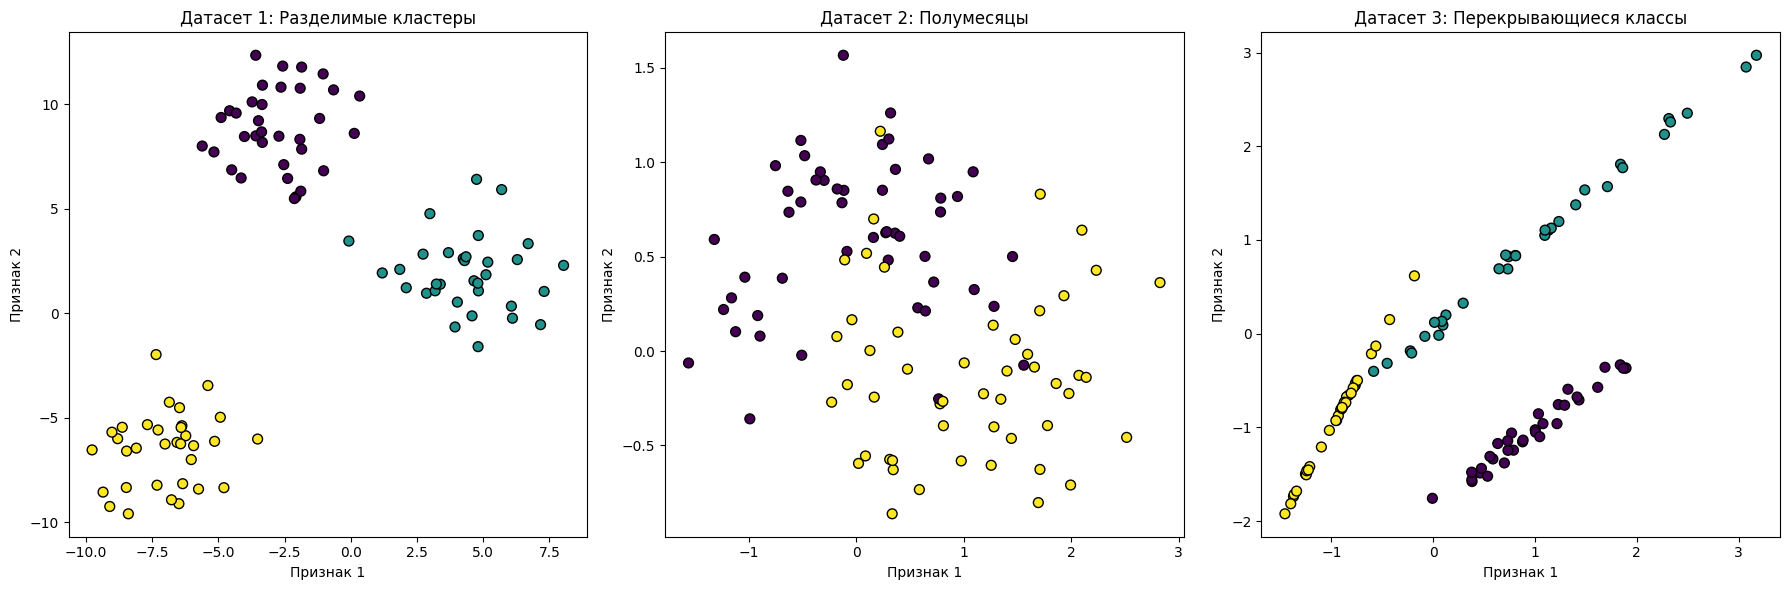

In [ ]:
# Визуализируем наборы данных
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Датасет 1: блобы
axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', s=50, edgecolor='k')
axes[0].set_title('Датасет 1: Разделимые кластеры')
axes[0].set_xlabel('Признак 1')
axes[0].set_ylabel('Признак 2')

# Датасет 2: полумесяцы
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', s=50, edgecolor='k')
axes[1].set_title('Датасет 2: Полумесяцы')
axes[1].set_xlabel('Признак 1')
axes[1].set_ylabel('Признак 2')

# Датасет 3: сложный
axes[2].scatter(X_complex[:, 0], X_complex[:, 1], c=y_complex, cmap='viridis', s=50, edgecolor='k')
axes[2].set_title('Датасет 3: Перекрывающиеся классы')
axes[2].set_xlabel('Признак 1')
axes[2].set_ylabel('Признак 2')

plt.tight_layout()
plt.show()


##3. Сравнение различных метрик расстояния

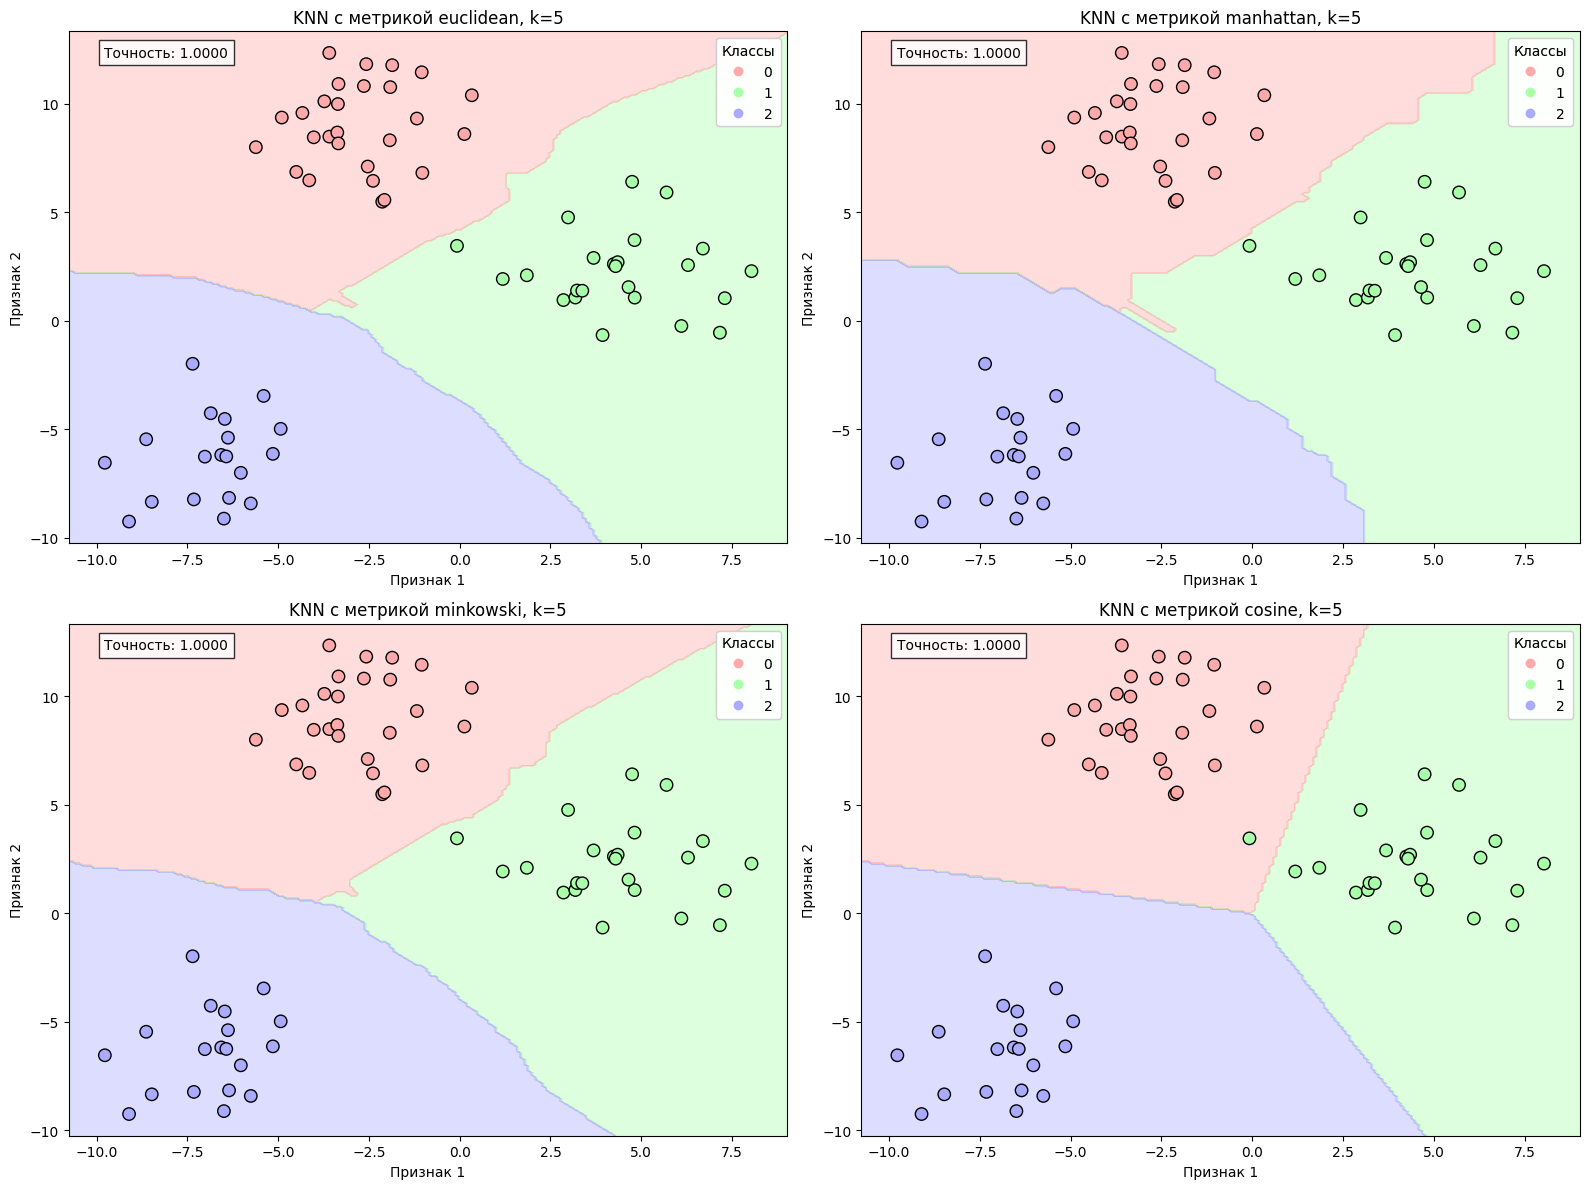

In [ ]:
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine']
k = 5  # Количество соседей

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    # Создаем и обучаем модель KNN
    knn = KNN(n_neighbors=k, metric=metric, p=3 if metric == 'minkowski' else 2)
    knn.fit(X_train_blobs, y_train_blobs)

    # Визуализируем границы принятия решений
    plot_decision_boundaries(X_train_blobs, y_train_blobs, knn, ax=axes[i],
                            title=f'KNN с метрикой {metric}, k={k}')

    # Вычисляем и отображаем точность
    accuracy = knn.score(X_test_blobs, y_test_blobs)
    axes[i].text(0.05, 0.95, f'Точность: {accuracy:.4f}', transform=axes[i].transAxes,
                 bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

##4. Влияние параметра k (числа соседей)

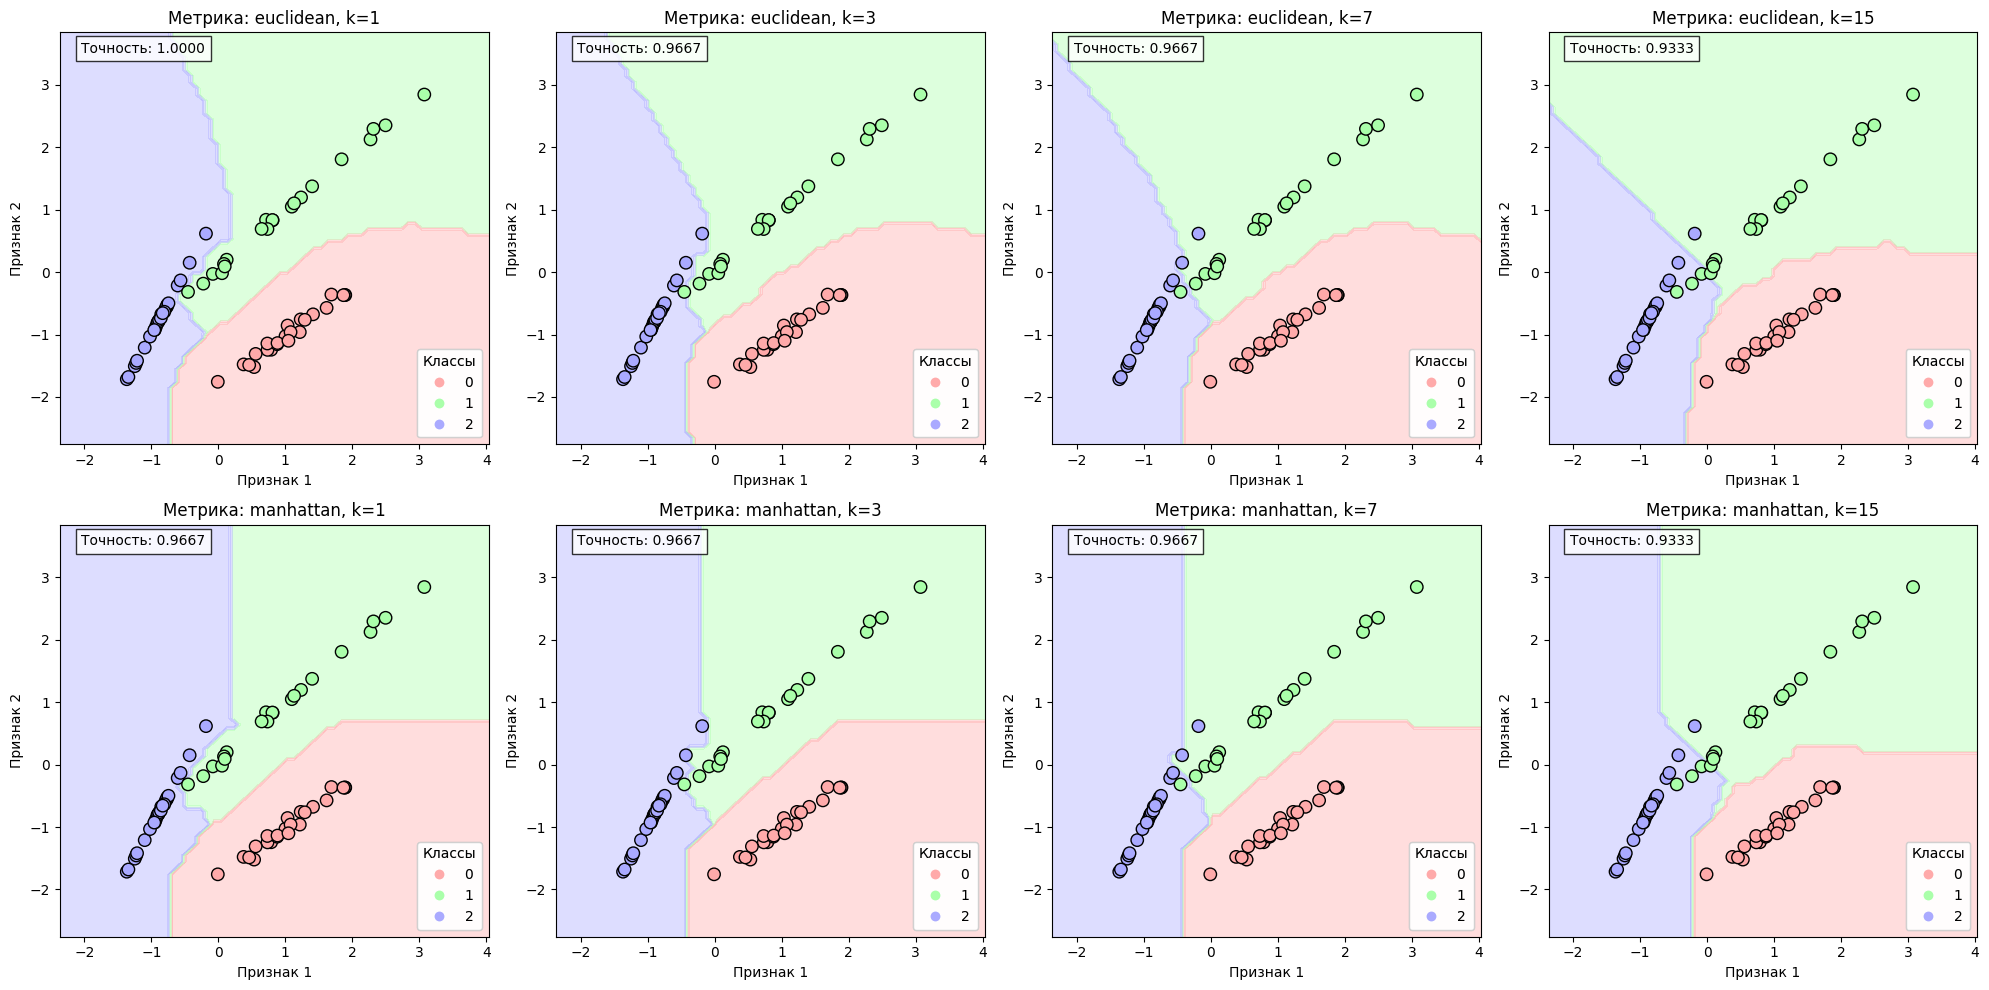

In [ ]:
# Посмотрим, как меняется точность и границы решения в зависимости от числа соседей
k_values = [1, 3, 7, 15]
metrics = ['euclidean', 'manhattan']

# Создаем сетку графиков
fig, axes = plt.subplots(len(metrics), len(k_values), figsize=(20, 10))

for i, metric in enumerate(metrics):
    for j, k in enumerate(k_values):
        # Создаем и обучаем модель KNN
        knn = KNN(n_neighbors=k, metric=metric)
        knn.fit(X_train_complex, y_train_complex)

        # Визуализируем границы принятия решений
        plot_decision_boundaries(X_train_complex, y_train_complex, knn, ax=axes[i, j],
                                title=f'Метрика: {metric}, k={k}')

        # Вычисляем и отображаем точность
        accuracy = knn.score(X_test_complex, y_test_complex)
        axes[i, j].text(0.05, 0.95, f'Точность: {accuracy:.4f}', transform=axes[i, j].transAxes,
                       bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


##5. Влияние схемы взвешивания соседей

In [ ]:
# Сравним равномерное и взвешенное по расстоянию голосование
weights_options = ['uniform', 'distance']
dataset_names = ['Блобы', 'Полумесяцы', 'Сложный набор']
datasets = [
    (X_train_blobs, y_train_blobs, X_test_blobs, y_test_blobs),
    (X_train_moons, y_train_moons, X_test_moons, y_test_moons),
    (X_train_complex, y_train_complex, X_test_complex, y_test_complex)
]

fig, axes = plt.subplots(len(datasets), len(weights_options), figsize=(16, 15))

for i, (dataset_name, (X_train, y_train, X_test, y_test)) in enumerate(zip(dataset_names, datasets)):
    for j, weights in enumerate(weights_options):
        # Создаем и обучаем модель KNN
        knn = KNN(n_neighbors=7, metric='euclidean', weights=weights)
        knn.fit(X_train, y_train)

        # Визуализируем границы принятия решений
        plot_decision_boundaries(X_train, y_train, knn, ax=axes[i, j],
                                title=f'{dataset_name}, вес: {weights}')

        # Вычисляем и отображаем точность
        accuracy = knn.score(X_test, y_test)
        axes[i, j].text(0.05, 0.95, f'Точность: {accuracy:.4f}', transform=axes[i, j].transAxes,
                       bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


##6. Сравнение с реализацией из sklearn

In [ ]:
# Выберем один набор данных для сравнения
X_train, y_train = X_train_complex, y_train_complex
X_test, y_test = X_test_complex, y_test_complex

# Подготовим таблицу для сравнения результатов
results = []

# Параметры для теста
k_values = [3, 5, 7]
metrics = ['euclidean', 'manhattan', 'minkowski']
weights_options = ['uniform', 'distance']

In [ ]:
for k in k_values:
    for metric in metrics:
        for weights in weights_options:
            # Наша реализация
            start_time = time.time()
            our_knn = KNN(n_neighbors=k, metric=metric, weights=weights, p=3 if metric == 'minkowski' else 2)
            our_knn.fit(X_train, y_train)
            our_accuracy = our_knn.score(X_test, y_test)
            our_time = time.time() - start_time

            # Реализация sklearn
            start_time = time.time()
            sklearn_metric = 'minkowski' if metric == 'euclidean' else metric
            sklearn_p = 2 if metric == 'euclidean' else (3 if metric == 'minkowski' else 1)
            sklearn_knn = KNeighborsClassifier(n_neighbors=k, metric=sklearn_metric, weights=weights, p=sklearn_p)
            sklearn_knn.fit(X_train, y_train)
            sklearn_accuracy = sklearn_knn.score(X_test, y_test)
            sklearn_time = time.time() - start_time

            # Добавляем результаты в таблицу
            results.append({
                'k': k,
                'metric': metric,
                'weights': weights,
                'our_accuracy': our_accuracy,
                'sklearn_accuracy': sklearn_accuracy,
                'our_time': our_time,
                'sklearn_time': sklearn_time
            })

# Создаем DataFrame для удобного отображения результатов
results_df = pd.DataFrame(results)
print("Сравнение точности и времени выполнения:")
print(results_df)

In [ ]:
# Визуальное сравнение лучших моделей
best_params = results_df.loc[results_df['sklearn_accuracy'].idxmax()]
k_best = int(best_params['k'])
metric_best = best_params['metric']
weights_best = best_params['weights']

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Наша реализация
our_knn = KNN(n_neighbors=k_best, metric=metric_best, weights=weights_best,
             p=3 if metric_best == 'minkowski' else 2)
our_knn.fit(X_train, y_train)
plot_decision_boundaries(X_train, y_train, our_knn, ax=axes[0],
                        title=f'Наша реализация KNN\nk={k_best}, метрика={metric_best}, вес={weights_best}')
axes[0].text(0.05, 0.95, f'Точность: {best_params["our_accuracy"]:.4f}', transform=axes[0].transAxes,
           bbox=dict(facecolor='white', alpha=0.8))

# Реализация sklearn
sklearn_metric = 'minkowski' if metric_best == 'euclidean' else metric_best
sklearn_p = 2 if metric_best == 'euclidean' else (3 if metric_best == 'minkowski' else 1)
sklearn_knn = KNeighborsClassifier(n_neighbors=k_best, metric=sklearn_metric, weights=weights_best, p=sklearn_p)
sklearn_knn.fit(X_train, y_train)
plot_decision_boundaries(X_train, y_train, sklearn_knn, ax=axes[1],
                        title=f'Реализация sklearn KNN\nk={k_best}, метрика={metric_best}, вес={weights_best}')
axes[1].text(0.05, 0.95, f'Точность: {best_params["sklearn_accuracy"]:.4f}', transform=axes[1].transAxes,
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

##7. Визуализация поиска ближайших соседей

In [ ]:
# Визуализация процесса поиска k ближайших соседей для указанной точки
def visualize_knn(X, y, query_point, k=5, metric='euclidean'):
    # Создаем модель KNN
    knn_model = NearestNeighbors(n_neighbors=k, metric=metric)
    knn_model.fit(X)

    # Поиск ближайших соседей
    distances, indices = knn_model.kneighbors([query_point])

    # Визуализация
    fig, ax = plt.subplots(figsize=(10, 8))

    # Отображение всех точек набора данных
    for label in np.unique(y):
        ax.scatter(X[y == label][:, 0], X[y == label][:, 1], label=f'Класс {label}', s=70)

    # Отображение точки запроса
    ax.scatter(query_point[0], query_point[1], c='red', label='Точка запроса', s=150, edgecolor='black')

    # Отображение k ближайших соседей
    for i, idx in enumerate(indices[0]):
        ax.annotate(f'{i+1}', (X[idx, 0], X[idx, 1]), fontsize=12, color='black')

    # Отображение окружности, включающей всех k ближайших соседей
    circle = Circle(query_point, radius=distances[0][-1], color='blue', alpha=0.2, linestyle='--',
                   edgecolor='black', fill=False)
    ax.add_patch(circle)

    # Подписи и легенда
    ax.legend()
    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    ax.set_title(f'Визуализация kNN с k={k}, метрика={metric}')
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')

    plt.grid(True)
    plt.show()

    # Определяем предсказанный класс
    predicted_class = np.argmax(np.bincount(y[indices[0]]))
    print(f"Предсказанный класс для точки {query_point}: {predicted_class}")
    print(f"Классы ближайших соседей: {y[indices[0]]}")
    print(f"Расстояния до соседей: {distances[0]}")

    return predicted_class

In [ ]:
# Проведем визуализацию на наборе данных с блобами
query_point = np.array([-2, 3])  # Точка, для которой ищем ближайших соседей
k = 7  # Количество ближайших соседей

In [ ]:
# Визуализация с евклидовой метрикой
predicted_euclidean = visualize_knn(X_blobs, y_blobs, query_point, k=k, metric='euclidean')


In [ ]:
# Визуализация с манхэттенской метрикой
predicted_manhattan = visualize_knn(X_blobs, y_blobs, query_point, k=k, metric='manhattan')


##8. Подбор оптимального параметра k

In [ ]:
# Проверим, как меняется точность в зависимости от значения k
k_range = range(1, 31, 2)
metrics = ['euclidean', 'manhattan', 'minkowski']
cv_scores = {}

X, y = X_complex, y_complex  # Используем сложный набор данных

for metric in metrics:
    cv_scores[metric] = []
    sklearn_p = 2 if metric == 'euclidean' else (3 if metric == 'minkowski' else 1)
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, p=sklearn_p)
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        cv_scores[metric].append(scores.mean())

# Визуализация результатов
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(k_range, cv_scores[metric], marker='o', label=f'Метрика {metric}')

plt.title('Зависимость точности от параметра k и метрики')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Средняя точность при кросс-валидации')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Найдем оптимальные значения k для каждой метрики
for metric in metrics:
    best_k = k_range[np.argmax(cv_scores[metric])]
    best_score = max(cv_scores[metric])
    print(f"Метрика {metric}: Лучшее значение k = {best_k}, точность = {best_score:.4f}")

## 9. Эффект нормализации данных на KNN

In [ ]:
# KNN очень чувствителен к масштабу признаков
# Создадим данные с разным масштабом
X_scaled = X_blobs.copy()
X_scaled[:, 1] = X_scaled[:, 1] * 10  # Увеличиваем масштаб второго признака

# Разделим на обучающую и тестовую выборки
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_blobs, test_size=0.3, random_state=42)

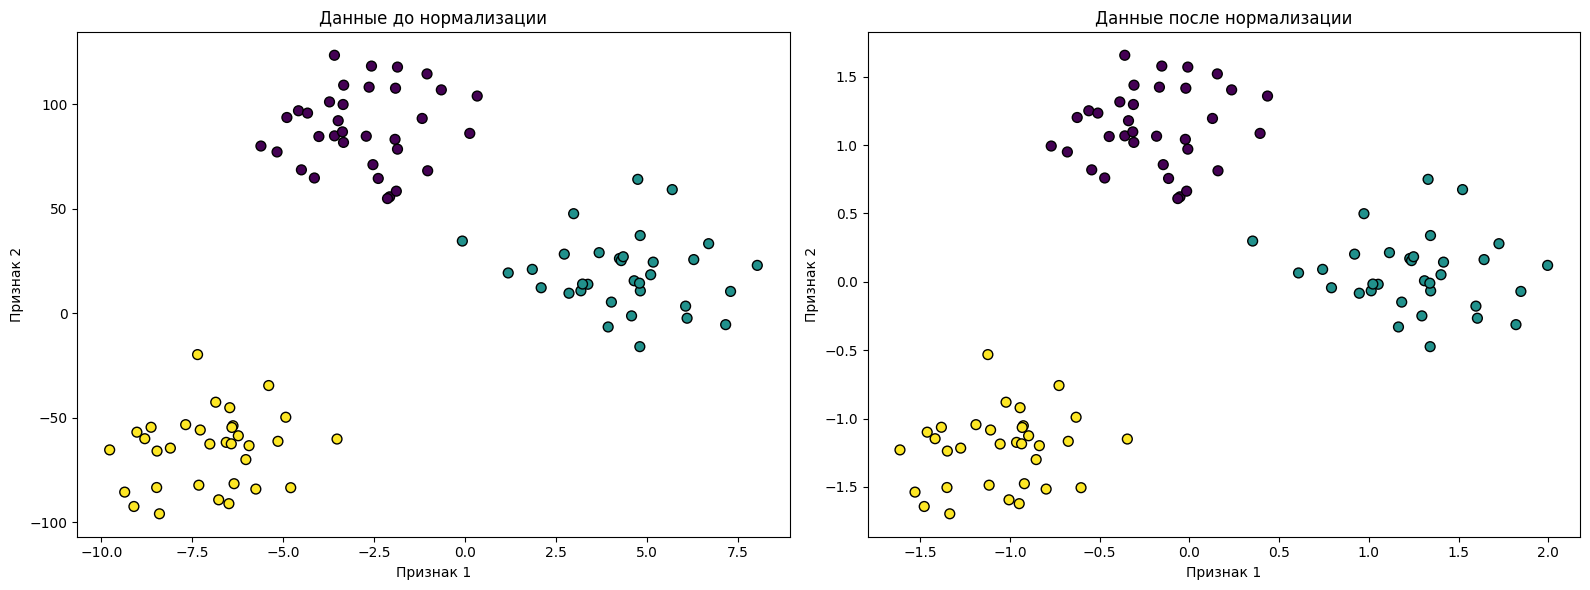

In [ ]:
# Визуализация до и после нормализации
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# До нормализации
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_blobs, cmap='viridis', s=50, edgecolor='k')
axes[0].set_title('Данные до нормализации')
axes[0].set_xlabel('Признак 1')
axes[0].set_ylabel('Признак 2')

# Применяем нормализацию
scaler = StandardScaler()
X_scaled_normalized = scaler.fit_transform(X_scaled)

# После нормализации
axes[1].scatter(X_scaled_normalized[:, 0], X_scaled_normalized[:, 1], c=y_blobs, cmap='viridis', s=50, edgecolor='k')
axes[1].set_title('Данные после нормализации')
axes[1].set_xlabel('Признак 1')
axes[1].set_ylabel('Признак 2')

plt.tight_layout()
plt.show()

In [ ]:
# Сравним точность KNN с нормализацией и без
# Без нормализации
knn_no_norm = KNeighborsClassifier(n_neighbors=5)
knn_no_norm.fit(X_train_scaled, y_train_scaled)
accuracy_no_norm = knn_no_norm.score(X_test_scaled, y_test_scaled)

# С нормализацией
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_scaled)
X_test_normalized = scaler.transform(X_test_scaled)

knn_with_norm = KNeighborsClassifier(n_neighbors=5)
knn_with_norm.fit(X_train_normalized, y_train_scaled)
accuracy_with_norm = knn_with_norm.score(X_test_normalized, y_test_scaled)

print(f"Точность без нормализации: {accuracy_no_norm:.4f}")
print(f"Точность с нормализацией: {accuracy_with_norm:.4f}")

Точность без нормализации: 1.0000
Точность с нормализацией: 1.0000


In [ ]:
# Визуализация границ решений
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Без нормализации
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_scaled)
plot_decision_boundaries(X_train_scaled, y_train_scaled, knn, ax=axes[0],
                        title=f'KNN без нормализации\nТочность: {accuracy_no_norm:.4f}')


In [ ]:
# С нормализацией
# Для визуализации мы должны создать специальную обертку, чтобы применять нормализацию к новым данным
class ScaledKNN:
    def __init__(self, knn, scaler):
        self.knn = knn
        self.scaler = scaler

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.knn.predict(X_scaled)

scaled_knn = ScaledKNN(knn_with_norm, scaler)
plot_decision_boundaries(X_train_scaled, y_train_scaled, scaled_knn, ax=axes[1],
                        title=f'KNN с нормализацией\nТочность: {accuracy_with_norm:.4f}')

plt.tight_layout()
plt.show()


## 10. Анализ производительности: время обучения и предсказания


In [ ]:
# Проанализируем, как размер набора данных влияет на время работы
n_samples = [100, 500, 1000, 2000, 5000]
train_times = []
predict_times = []
sklearn_train_times = []
sklearn_predict_times = []

In [ ]:
for n in n_samples:
    # Генерируем данные
    X, y = make_blobs(n_samples=n, centers=3, cluster_std=1.8, random_state=42)
    X_train, X_test = train_test_split(X, train_size=0.8, random_state=42)
    y_train, y_test = y[:len(X_train)], y[len(X_train):]

    # Наша реализация
    start_time = time.time()
    our_knn = KNN(n_neighbors=5, metric='euclidean')
    our_knn.fit(X_train, y_train)
    train_times.append(time.time() - start_time)

    start_time = time.time()
    our_knn.predict(X_test)
    predict_times.append(time.time() - start_time)

    # Реализация sklearn
    start_time = time.time()
    sklearn_knn = KNeighborsClassifier(n_neighbors=5)
    sklearn_knn.fit(X_train, y_train)
    sklearn_train_times.append(time.time() - start_time)

    start_time = time.time()
    sklearn_knn.predict(X_test)
    sklearn_predict_times.append(time.time() - start_time)

In [ ]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Время обучения
axes[0].plot(n_samples, train_times, marker='o', label='Наша реализация')
axes[0].plot(n_samples, sklearn_train_times, marker='s', label='sklearn')
axes[0].set_title('Время обучения')
axes[0].set_xlabel('Размер набора данных')
axes[0].set_ylabel('Время (сек)')
axes[0].legend()
axes[0].grid(True)

# Время предсказания
axes[1].plot(n_samples, predict_times, marker='o', label='Наша реализация')
axes[1].plot(n_samples, sklearn_predict_times, marker='s', label='sklearn')
axes[1].set_title('Время предсказания')
axes[1].set_xlabel('Размер набора данных')
axes[1].set_ylabel('Время (сек)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 11. Матрица ошибок

In [ ]:
# Построим матрицу ошибок для лучшей модели на сложном наборе данных
X, y = X_complex, y_complex
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Находим оптимальные параметры из предыдущего анализа
best_metric = metrics[np.argmax([max(cv_scores[m]) for m in metrics])]
best_k = k_range[np.argmax(cv_scores[best_metric])]

In [ ]:
# Создаем и обучаем модель
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Матрица ошибок для KNN (k={best_k}, метрика={best_metric})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


In [ ]:
# Точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.4f}")

## 12. Заключения


### Ключевые выводы:

1. **Метрики расстояния**: Выбор метрики значительно влияет на результаты. Евклидова метрика обычно дает хорошие результаты для большинства задач, но для специфических данных другие метрики могут работать лучше.

2. **Параметр k**: Меньшие значения k приводят к более гибким границам, но могут вызвать переобучение. Большие значения k дают более сглаженные границы, но могут пропустить важные закономерности в данных.

3. **Взвешивание**: Взвешенный KNN часто дает лучшие результаты, особенно на сложных наборах данных.

4. **Нормализация данных**: KNN чувствителен к масштабу признаков. Нормализация данных значительно улучшает точность, когда признаки измеряются в разных шкалах.

5. **Производительность**: Наша собственная реализация может быть эффективной для небольших наборов данных, но sklearn оптимизирована для больших объемов данных.

### Практические рекомендации:

1. Всегда нормализуйте данные перед применением KNN.
2. Используйте кросс-валидацию для подбора оптимального значения k.
3. Экспериментируйте с разными метриками расстояния.
4. Для больших наборов данных используйте оптимизированные реализации (например, из sklearn).
5. Для несбалансированных классов рассмотрите взвешенный KNN.
